In [1]:
# add path:
data_path = '../datasets/DRIVE_dataset/datasets/'

# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
import random
import torch.nn as nn
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
from IPython.display import display, clear_output
from tqdm import tqdm
import os
### our modules
from dataset import *
from training import *
from testing import *
####
# Check whether we're using a GPU
if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()  # Total number of GPUs
    gpu_idx = random.randint(0, n_gpus - 1)  # Random GPU index
    device = torch.device(f'cuda:{gpu_idx}')
    print('Using GPU: {}'.format(device))
else:
    device = torch.device('cpu')
    print('GPU not found. Using CPU.')

Using GPU: cuda:1


In [3]:
train_dict_list = build_dict_vessels(data_path, mode='training')
test_dict_list = build_dict_vessels(data_path, mode='test')
print(test_dict_list)
print(f'Number of samples in the training dataset: {len(train_dict_list)}')

[{'img': '../DRIVE_dataset/datasets/test/images/01_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/02_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/03_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/04_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/05_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/06_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/07_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/08_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/09_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/10_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/11_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/12_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/13_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/14_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/15_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/16_test.tif'}, {'img':

In [201]:
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirstd, ScaleIntensityd, NormalizeIntensityd, Resized,
    RandFlipd, RandRotate90d, RandZoomd, RandAffined, RandGaussianNoised, RandAdjustContrastd
)

train_transforms = Compose([
    LoadVesselData(),

    # Resize (64x64 for training)
    Resized(keys="img", spatial_size=(64, 64), mode="bilinear"),
    Resized(keys="mask", spatial_size=(64, 64), mode="nearest"),
])
# ==== AUGMENTATIONS ====
"""RandFlipd(keys="img", spatial_axis=0, prob=0.5),
RandFlipd(keys="img", spatial_axis=1, prob=0.5),
RandRotate90d(keys="img", prob=0.5),
RandZoomd(keys="img", min_zoom=0.9, max_zoom=1.2, prob=0.4),
RandAffined(
    keys="img",
    rotate_range=(0.1, 0.1),
    shear_range=(0.1, 0.1),
    translate_range=(6, 6),
    scale_range=(0.15, 0.15),
    prob=0.5,
    mode="bilinear"
),
RandGaussianNoised(keys="img", prob=0.3, mean=0.0, std=0.1),
RandAdjustContrastd(keys="img", prob=0.4, gamma=(0.6, 1.4)),

# ==== FINAL NORMALIZATION ====
EnsureChannelFirstd(keys="img", strict_check=False),
ScaleIntensityd(keys="img", minv=0.0, maxv=1.0),
NormalizeIntensityd(keys="img", subtrahend=0.5, divisor=0.5),
"""


'RandFlipd(keys="img", spatial_axis=0, prob=0.5),\nRandFlipd(keys="img", spatial_axis=1, prob=0.5),\nRandRotate90d(keys="img", prob=0.5),\nRandZoomd(keys="img", min_zoom=0.9, max_zoom=1.2, prob=0.4),\nRandAffined(\n    keys="img",\n    rotate_range=(0.1, 0.1),\n    shear_range=(0.1, 0.1),\n    translate_range=(6, 6),\n    scale_range=(0.15, 0.15),\n    prob=0.5,\n    mode="bilinear"\n),\nRandGaussianNoised(keys="img", prob=0.3, mean=0.0, std=0.1),\nRandAdjustContrastd(keys="img", prob=0.4, gamma=(0.6, 1.4)),\n\n# ==== FINAL NORMALIZATION ====\nEnsureChannelFirstd(keys="img", strict_check=False),\nScaleIntensityd(keys="img", minv=0.0, maxv=1.0),\nNormalizeIntensityd(keys="img", subtrahend=0.5, divisor=0.5),\n'

In [202]:
data_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [203]:
latent_dim = 64

In [204]:
# IMPORT IMAGES FROM VASCUSYNTH
import torchvision
class VascuSynthImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Converte in scala di grigi
        if self.transform:
            image = self.transform(image)
        return image, 0  # Il secondo valore è un segnaposto per l'etichetta

# Definizione delle trasformazioni
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Carica il dataset
dataset = VascuSynthImageDataset('../VS_images', transform=transform)
data_loader2 = DataLoader(dataset, batch_size=12, shuffle=True)

In [205]:
class Discriminator_CNN(nn.Module):
    def __init__(self, ndf=64, input_channels=2):
        super(Discriminator_CNN, self).__init__()

        self.main = nn.Sequential(
            # Input: (2) x 64 x 64
            nn.Conv2d(input_channels, ndf, 4, 2, 1),   # -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),           # -> 16x16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),       # -> 8x8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 2, 1),             # -> 4x4
            nn.Sigmoid()
        )

    def forward(self, x):  # x: [B, 2, 64, 64]
        x = self.main(x)   # [B, 1, 4, 4]
        return x.mean(dim=[2, 3])  # → [B, 1]


In [206]:
class Generator_CNN(nn.Module):
    def __init__(self, latent_dim=64, ngf=64, output_channels=1):
        super(Generator_CNN, self).__init__()

        in_channels = latent_dim + 1  # 1 = mask channel

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, ngf * 4, 3, 1, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Conv2d(ngf * 4, ngf * 2, 3, 1, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf, 3, 1, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, output_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [207]:
# Get networks
discriminator = Discriminator_CNN()
generator = Generator_CNN()

# Push networks to device
discriminator.to(device)
generator.to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss = torch.nn.BCELoss()

In [208]:
# Save model checkpoint in a folder called 'saved_models'
def saveModels(epoch, model_name):
    to_save = {
        'epoch': epoch,
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_gen': optimizer_gen.state_dict(),
        'optimizer_dis': optimizer_dis.state_dict()
    }
    directory = os.path.join('saved_models', model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    torch.save(to_save, os.path.join(directory, 'Epoch_{}.pt'.format(epoch)))
    
# Plot generated images in a grid
"""def plotGeneratedImages(epoch, examples=9, dim=(3, 3), figsize=(10, 10)):
    with torch.no_grad():
        noise = torch.normal(0, 1, size=(examples, latent_dim), device=device)
        fake_images = generator(noise).cpu().numpy()
        fake_images = fake_images.reshape(examples, 512, 512)

        fig = plt.figure(figsize=figsize)
        fig.suptitle('Epoch {}'.format(epoch), fontsize=14)
        for i in range(fake_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(fake_images[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        return fig
"""
    
def plotGeneratedImages(epoch, examples=9, dim=(3, 3), figsize=(6, 6)):
    generator.eval()

    # Generate noise and random masks
    noise = torch.randn(examples, latent_dim, 1, 1, device=device)
    noise = noise.expand(-1, -1, 64, 64)  # Match mask spatial size

    # Generate fake masks to condition on (can be improved by using real ones)
    fake_masks = torch.rand(examples, 1, 64, 64, device=device)  # Random noise as mask
    fake_masks = (fake_masks > 0.5).float()  # Make them binary-ish (optional)

    # Concatenate [noise | mask] as input to generator
    gen_input = torch.cat((noise, fake_masks), dim=1)

    with torch.no_grad():
        fake_images = generator(gen_input).cpu()

    fake_images = (fake_images + 1) / 2  # Denormalize to [0, 1]

    fig, axes = plt.subplots(*dim, figsize=figsize)
    fig.suptitle(f"Generated Images at Epoch {epoch}", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        img = fake_images[i].squeeze().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    generator.train()
    return fig


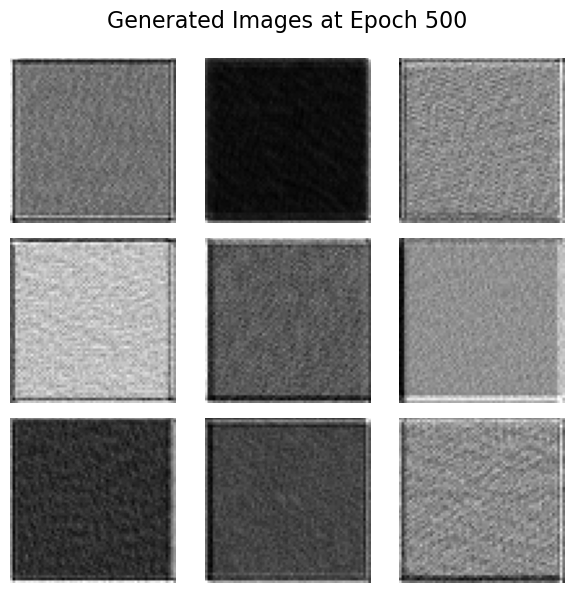

In [209]:
dis_losses = []
gen_losses = []

epochs = 500  ###
batch_size = 5
fig = None

for epoch in range(1, epochs + 1):
    
    # Wrap dataloader into tqdm such that we can print progress while training
    with tqdm(data_loader, unit="iterations") as tqdm_iterator:
        tqdm_iterator.set_description('Epoch {}'.format(epoch))
        
        for i, batch in enumerate(tqdm_iterator):

            # ========== Train Discriminator ==========
            
            # Freeze generator part
            for param in generator.parameters():
                param.requires_grad = False
            for param in discriminator.parameters():
                param.requires_grad = True
            discriminator.zero_grad()

            # Get real images and flatten the image dimensions
            # Get real images and masks
            real_images = batch['img'].to(device)
            real_masks = batch['mask'].to(device)
            real_batch_size = real_images.size(0)

            # -------- Discriminator Training --------
            # Create fake images from noise + mask
            # Sample and expand noise
            noise = torch.randn(real_batch_size, latent_dim, 1, 1, device=device)
            noise = noise.expand(-1, -1, 64, 64)  # Broadcast to match mask spatially

            # Concatenate noise + mask as input to generator
            gen_input = torch.cat((noise, real_masks), dim=1)  # [B, latent_dim + 1, 64, 64]

            fake_images = generator(gen_input)

            # Discriminator sees real and fake pairs
            real_pair = torch.cat((real_images, real_masks), dim=1)  # [B, 2, 64, 64]
            fake_pair = torch.cat((fake_images, real_masks), dim=1)  # [B, 2, 64, 64]

            dis_input = torch.cat((real_pair, fake_pair), dim=0)  # [2B, 2, 64, 64]
            dis_labels = torch.zeros((2 * real_batch_size, 1), device=device)
            dis_labels[:real_batch_size] = 0.9

            # Train discriminator
            predictions = discriminator(dis_input)
            dis_loss = loss(predictions, dis_labels)
            dis_loss.backward()
            optimizer_dis.step()
            dis_losses.append(dis_loss.detach().cpu().numpy())

            # -------- Generator Training --------
            generator.zero_grad()
            ##noise = torch.randn(real_batch_size, latent_dim, device=device).view(real_batch_size, latent_dim, 1, 1)
            noise = noise.expand(-1, -1, 64, 64)  # [B, latent_dim, 64, 64]
            gen_input = torch.cat((noise, real_masks), dim=1)  # ✅ [B, latent_dim + 1, 64, 64]
            fake_images = generator(gen_input)

            fake_pair = torch.cat((fake_images, real_masks), dim=1)
            gen_labels = torch.ones((real_batch_size, 1), device=device)

            predictions = discriminator(fake_pair)
            gen_loss = loss(predictions, gen_labels)
            gen_loss.backward()
            optimizer_gen.step()
            gen_losses.append(gen_loss.detach().cpu().numpy())

    # Display generated images every 5th epoch
    if epoch % 10 == 0:
        clear_output(wait=True)
        fig = plotGeneratedImages(epoch)
        saveModels(epoch, 'CNN_GAN')

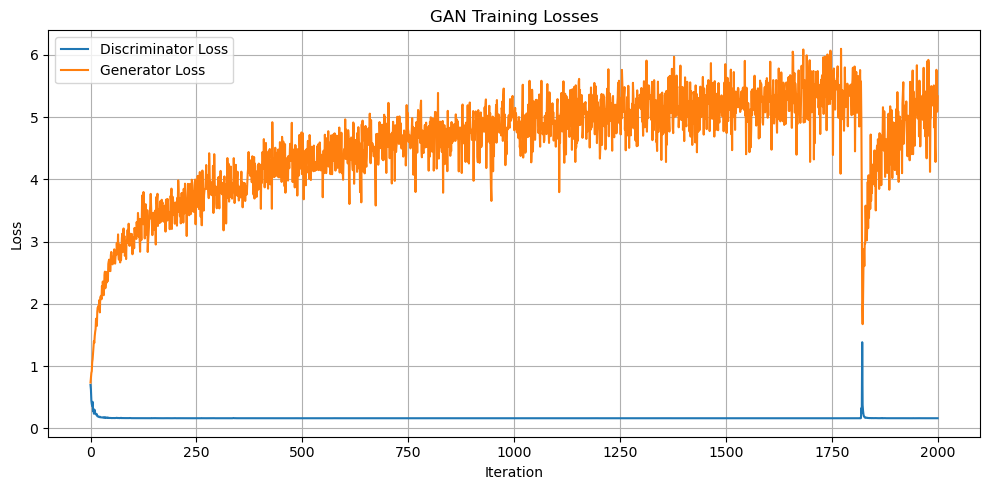

In [210]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gan_losses(dis_losses, gen_losses, batch_size):
    # Convert lists to numpy arrays for easier slicing
    dis_losses = np.array(dis_losses)
    gen_losses = np.array(gen_losses)

    # Create an x-axis based on batch iterations
    iterations = np.arange(len(dis_losses))

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, dis_losses, label="Discriminator Loss")
    plt.plot(iterations, gen_losses, label="Generator Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("GAN Training Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_gan_losses(dis_losses, gen_losses, batch_size)

In [119]:
print("real_images.shape:", real_images.shape)
print("fake_images.shape:", fake_images.shape)
print("dis_input.shape:", dis_input.shape)

predictions = discriminator(dis_input)
print("predictions.shape:", predictions.shape)
print("dis_labels.shape:", dis_labels.shape)


real_images.shape: torch.Size([5, 1, 64, 64])
fake_images.shape: torch.Size([5, 1, 64, 64])
dis_input.shape: torch.Size([10, 1, 64, 64])
predictions.shape: torch.Size([90, 1])
dis_labels.shape: torch.Size([10, 1])
